In [1]:
! pip install transformers
! pip install pycaret

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import DistilBertModel, DistilBertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

In [3]:
# #Working on google collab
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/FakeNewsDetection2

true_data = pd.read_csv('a1_True.csv')
fake_data = pd.read_csv('a2_Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index(drop=True)

# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,New U.S. rule on class actions survives first ...,WASHINGTON (Reuters) - A new U.S. rule aimed a...,politicsNews,"July 31, 2017",True
1,Turkish soldier killed in PKK attack in southe...,ISTANBUL (Reuters) - A Turkish military vehicl...,worldnews,"October 23, 2017",True
2,WOW! OBAMA Just DESTROYED Hillary With This Tw...,Here s the video clip that captured Hillary in...,politics,"Sep 11, 2016",Fake
3,Senate confirms Trump's agriculture secretary,WASHINGTON (Reuters) - The U.S. Senate on Mond...,politicsNews,"April 24, 2017",True
4,Boiler Room EP #114 – Psychos In The Compromis...,Tune in to the Alternate Current Radio Network...,Middle-east,"June 24, 2017",Fake


In [4]:
data['label'] = pd.get_dummies(data.Target)['True']

In [5]:
data.head()

,title,text,subject,date,Target,label
0,New U.S. rule on class actions survives first ...,WASHINGTON (Reuters) - A new U.S. rule aimed a...,politicsNews,"July 31, 2017",True,1
1,Turkish soldier killed in PKK attack in southe...,ISTANBUL (Reuters) - A Turkish military vehicl...,worldnews,"October 23, 2017",True,1
2,WOW! OBAMA Just DESTROYED Hillary With This Tw...,Here s the video clip that captured Hillary in...,politics,"Sep 11, 2016",Fake,0
3,Senate confirms Trump's agriculture secretary,WASHINGTON (Reuters) - The U.S. Senate on Mond...,politicsNews,"April 24, 2017",True,1
4,Boiler Room EP #114 – Psychos In The Compromis...,Tune in to the Alternate Current Radio Network...,Middle-east,"June 24, 2017",Fake,0


([<matplotlib.patches.Wedge at 0x1acf1625550>,
 [Text(-1.1968727148445069, 0.08657773651892332, 'Fake'),
  Text(1.1968727229504943, -0.08657762445961172, 'True')],
 [Text(-0.6981757503259622, 0.050503679636038606, '47.7%'),
  Text(0.698175755054455, -0.05050361426810683, '52.3%')])

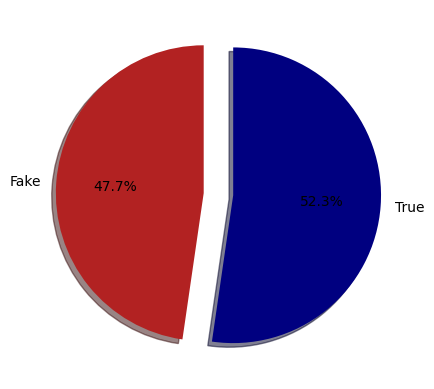

In [6]:
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [7]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [8]:
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Text(0, 0.5, 'Number of texts')

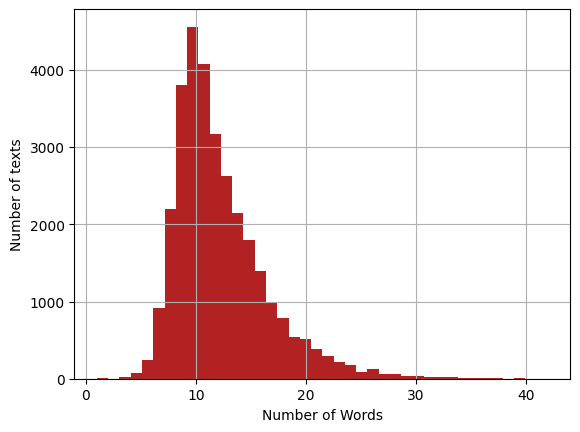

In [9]:
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [10]:
sample_data = ["Build fake news model.",
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [11]:
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [12]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 50                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [14]:
for param in bert.parameters():
    param.requires_grad = False

In [15]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      outputs = self.bert(sent_id, attention_mask=mask)
      pooler_output = outputs['last_hidden_state'][:, 0, :]
                                                # pass the inputs to the model
      x = self.fc1(pooler_output)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 10

In [16]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [17]:
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'DistilBert_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    629.
  Batch   100  of    629.
  Batch   150  of    629.
  Batch   200  of    629.
  Batch   250  of    629.
  Batch   300  of    629.
  Batch   350  of    629.
  Batch   400  of    629.
  Batch   450  of    629.
  Batch   500  of    629.
  Batch   550  of    629.
  Batch   600  of    629.

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.506
Validation Loss: 0.360

 Epoch 2 / 10
  Batch    50  of    629.
  Batch   100  of    629.
  Batch   150  of    629.
  Batch   200  of    629.
  Batch   250  of    629.
  Batch   300  of    629.
  Batch   350  of    629.
  Batch   400  of    629.
  Batch   450  of    629.
  Batch   500  of    629.
  Batch   550  of    629.
  Batch   600  of    629.

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.324
Validation Loss: 0.284

 Epoch 3 / 10
  Batch    50  of    629.
  Batch   100  of    629.
  Batch   150  of    629.
  Batch   200  of    629.
  B

In [18]:
# path = 'DistilBert_weights.pt'
# model.load_state_dict(torch.load(path))

In [19]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3523
           1       0.91      0.93      0.92      3212

    accuracy                           0.93      6735
   macro avg       0.93      0.93      0.93      6735
weighted avg       0.93      0.93      0.93      6735



In [20]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([0, 0, 1, 1], dtype=int64)

In [21]:
# testing on unseen data
unseen_news_text = [
    "President Obama and Vice President Biden never even tried to fix this (police reforms) during their..."  # Fake
]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length=MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    probs = torch.nn.functional.softmax(preds, dim=-1)
    preds = np.argmax(preds, axis=1)

# Convert 0 and 1 to class labels
class_labels = ['Fake', 'Real']
pred_labels = [class_labels[pred] for pred in preds]

# Print the percentage confidence for each class
for i, label in enumerate(class_labels):
    print(f'Percentage of {label} predictions: {probs[0, i].item() * 100:.2f}%')


Percentage of Fake predictions: 95.64%
Percentage of Real predictions: 4.36%
